In [123]:
import os
import numpy as np
from sgfmill import sgf, sgf_moves

BOARD_SIZE = 19
NUM_TRAINING_GAMES = 3000
NUM_TEST_GAMES = 100

In [122]:
path = 'd:\\temp\\go\\games'

game_files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.sgf' in file:
            game_files.append(os.path.join(r, file))

print('Total games: %s'  % len(game_files))

Total games: 11796


In [124]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using %s' % torch.cuda.get_device_name(device=None))
else:
    device = torch.device('cpu')
    print('Using CPU')

def data_point(board, move, color):
    board_array = torch.zeros((1, BOARD_SIZE, BOARD_SIZE), dtype=torch.float32, device=device)
    for p in board.list_occupied_points():
        board_array[0, p[1][0], p[1][1]] = -1.0 + 2 * int(p[0] == color)
    return board_array, move[0]*BOARD_SIZE+move[1]

def make_data_points(game_files):
    data_points = []
    for i, game_file in enumerate(game_files):
        print('Processing %s/%s: %s' % (i, len(game_files), game_file))
        with open(game_file) as f:
            contents = f.read().encode('ascii')
            game = sgf.Sgf_game.from_bytes(contents)
            board, plays = sgf_moves.get_setup_and_moves(game)
            for color, move in plays:
                if move is None: continue
                row, col = move
                tp = data_point(board, move, color)
                data_points.append(tp)
                board.play(row, col, color)
    return data_points

class GoDataset(data.Dataset):
    def __init__(self, data_points):
        self.data_points = data_points
    def __getitem__(self, index):
        return self.data_points[index][0], self.data_points[index][1]
    def __len__(self):
        return len(self.data_points)

training_game_files = game_files[:NUM_TRAINING_GAMES]
test_game_files = game_files[-NUM_TEST_GAMES:]
training_points = make_data_points(training_game_files)
test_points = make_data_points(test_game_files)
print('Total training moves: %s' % len(training_points))
print('Total test moves: %s' % len(test_points))
training_dataset = GoDataset(training_points)
test_dataset = GoDataset(test_points)
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=True)

Using GeForce GTX 970
Processing 0/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-01-1.sgf
Processing 1/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-01-10.sgf
Processing 2/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-01-11.sgf
Processing 3/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-01-12.sgf
Processing 4/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-01-13.sgf
Processing 5/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-01-14.sgf
Processing 6/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-01-15.sgf
Processing 7/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-01-16.sgf
Processing 8/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-01-17.sgf
Processing 9/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-01-18.sgf
Processing 10/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-01-19.sgf
Processing 11/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-01-2.sgf
Processing 12/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-01-20.sgf
Processing 13/3000: d:\temp\

Processing 112/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-04-20.sgf
Processing 113/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-04-21.sgf
Processing 114/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-04-22.sgf
Processing 115/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-04-23.sgf
Processing 116/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-04-24.sgf
Processing 117/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-04-25.sgf
Processing 118/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-04-26.sgf
Processing 119/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-04-3.sgf
Processing 120/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-04-4.sgf
Processing 121/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-04-5.sgf
Processing 122/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-04-6.sgf
Processing 123/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-04-7.sgf
Processing 124/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-04-8.sgf
Processing 125/3000: d:\temp\go

Processing 222/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-09-7.sgf
Processing 223/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-09-8.sgf
Processing 224/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-09-9.sgf
Processing 225/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-10-1.sgf
Processing 226/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-10-2.sgf
Processing 227/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-10-3.sgf
Processing 228/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-10-4.sgf
Processing 229/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-10-5.sgf
Processing 230/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-10-6.sgf
Processing 231/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-10-7.sgf
Processing 232/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-11-1.sgf
Processing 233/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-11-10.sgf
Processing 234/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-11-11.sgf
Processing 235/3000: d:\temp\go\game

Processing 332/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-16-17.sgf
Processing 333/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-16-18.sgf
Processing 334/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-16-19.sgf
Processing 335/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-16-2.sgf
Processing 336/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-16-20.sgf
Processing 337/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-16-21.sgf
Processing 338/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-16-22.sgf
Processing 339/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-16-23.sgf
Processing 340/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-16-24.sgf
Processing 341/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-16-25.sgf
Processing 342/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-16-26.sgf
Processing 343/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-16-27.sgf
Processing 344/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-16-3.sgf
Processing 345/3000: d:\tem

Processing 442/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-22-2.sgf
Processing 443/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-22-20.sgf
Processing 444/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-22-21.sgf
Processing 445/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-22-22.sgf
Processing 446/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-22-23.sgf
Processing 447/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-22-24.sgf
Processing 448/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-22-25.sgf
Processing 449/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-22-26.sgf
Processing 450/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-22-27.sgf
Processing 451/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-22-28.sgf
Processing 452/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-22-29.sgf
Processing 453/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-22-3.sgf
Processing 454/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-22-30.sgf
Processing 455/3000: d:\tem

Processing 552/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-25-23.sgf
Processing 553/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-25-24.sgf
Processing 554/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-25-25.sgf
Processing 555/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-25-26.sgf
Processing 556/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-25-27.sgf
Processing 557/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-25-28.sgf
Processing 558/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-25-29.sgf
Processing 559/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-25-3.sgf
Processing 560/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-25-30.sgf
Processing 561/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-25-31.sgf
Processing 562/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-25-32.sgf
Processing 563/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-25-33.sgf
Processing 564/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-25-34.sgf
Processing 565/3000: d:\te

Processing 662/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-27-49.sgf
Processing 663/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-27-5.sgf
Processing 664/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-27-50.sgf
Processing 665/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-27-51.sgf
Processing 666/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-27-52.sgf
Processing 667/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-27-53.sgf
Processing 668/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-27-54.sgf
Processing 669/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-27-55.sgf
Processing 670/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-27-56.sgf
Processing 671/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-27-57.sgf
Processing 672/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-27-58.sgf
Processing 673/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-27-59.sgf
Processing 674/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-27-6.sgf
Processing 675/3000: d:\tem

Processing 772/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-29-24.sgf
Processing 773/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-29-25.sgf
Processing 774/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-29-26.sgf
Processing 775/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-29-27.sgf
Processing 776/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-29-28.sgf
Processing 777/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-29-29.sgf
Processing 778/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-29-3.sgf
Processing 779/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-29-30.sgf
Processing 780/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-29-31.sgf
Processing 781/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-29-32.sgf
Processing 782/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-29-33.sgf
Processing 783/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-29-34.sgf
Processing 784/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-29-35.sgf
Processing 785/3000: d:\te

Processing 882/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-30-65.sgf
Processing 883/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-30-7.sgf
Processing 884/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-30-8.sgf
Processing 885/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-30-9.sgf
Processing 886/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-31-1.sgf
Processing 887/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-31-10.sgf
Processing 888/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-31-11.sgf
Processing 889/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-31-12.sgf
Processing 890/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-31-13.sgf
Processing 891/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-31-14.sgf
Processing 892/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-31-15.sgf
Processing 893/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-31-16.sgf
Processing 894/3000: d:\temp\go\games\kgs-19-2018-07-new\2018-07-31-17.sgf
Processing 895/3000: d:\temp\

Processing 992/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-02-20.sgf
Processing 993/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-02-21.sgf
Processing 994/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-02-22.sgf
Processing 995/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-02-23.sgf
Processing 996/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-02-24.sgf
Processing 997/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-02-25.sgf
Processing 998/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-02-26.sgf
Processing 999/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-02-27.sgf
Processing 1000/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-02-28.sgf
Processing 1001/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-02-29.sgf
Processing 1002/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-02-3.sgf
Processing 1003/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-02-30.sgf
Processing 1004/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-02-31.sgf
Processing 1005/3000:

Processing 1101/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-04-24.sgf
Processing 1102/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-04-25.sgf
Processing 1103/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-04-26.sgf
Processing 1104/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-04-27.sgf
Processing 1105/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-04-28.sgf
Processing 1106/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-04-29.sgf
Processing 1107/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-04-3.sgf
Processing 1108/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-04-30.sgf
Processing 1109/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-04-31.sgf
Processing 1110/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-04-32.sgf
Processing 1111/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-04-33.sgf
Processing 1112/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-04-34.sgf
Processing 1113/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-04-35.sgf
Processing 11

Processing 1209/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-05-8.sgf
Processing 1210/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-05-9.sgf
Processing 1211/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-06-1.sgf
Processing 1212/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-06-10.sgf
Processing 1213/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-06-11.sgf
Processing 1214/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-06-12.sgf
Processing 1215/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-06-13.sgf
Processing 1216/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-06-14.sgf
Processing 1217/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-06-15.sgf
Processing 1218/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-06-16.sgf
Processing 1219/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-06-17.sgf
Processing 1220/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-06-18.sgf
Processing 1221/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-06-19.sgf
Processing 1222

Processing 1318/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-09-27.sgf
Processing 1319/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-09-28.sgf
Processing 1320/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-09-29.sgf
Processing 1321/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-09-3.sgf
Processing 1322/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-09-4.sgf
Processing 1323/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-09-5.sgf
Processing 1324/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-09-6.sgf
Processing 1325/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-09-7.sgf
Processing 1326/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-09-8.sgf
Processing 1327/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-09-9.sgf
Processing 1328/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-10-1.sgf
Processing 1329/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-10-10.sgf
Processing 1330/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-10-11.sgf
Processing 1331/3000

Processing 1427/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-12-12.sgf
Processing 1428/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-12-13.sgf
Processing 1429/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-12-14.sgf
Processing 1430/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-12-15.sgf
Processing 1431/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-12-16.sgf
Processing 1432/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-12-17.sgf
Processing 1433/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-12-18.sgf
Processing 1434/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-12-19.sgf
Processing 1435/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-12-2.sgf
Processing 1436/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-12-20.sgf
Processing 1437/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-12-21.sgf
Processing 1438/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-12-22.sgf
Processing 1439/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-12-23.sgf
Processing 14

Processing 1536/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-14-5.sgf
Processing 1537/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-14-6.sgf
Processing 1538/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-14-7.sgf
Processing 1539/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-14-8.sgf
Processing 1540/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-14-9.sgf
Processing 1541/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-15-1.sgf
Processing 1542/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-15-10.sgf
Processing 1543/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-15-11.sgf
Processing 1544/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-15-12.sgf
Processing 1545/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-15-13.sgf
Processing 1546/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-15-2.sgf
Processing 1547/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-15-3.sgf
Processing 1548/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-15-4.sgf
Processing 1549/3000:

Processing 1645/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-18-44.sgf
Processing 1646/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-18-5.sgf
Processing 1647/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-18-6.sgf
Processing 1648/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-18-7.sgf
Processing 1649/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-18-8.sgf
Processing 1650/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-18-9.sgf
Processing 1651/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-19-1.sgf
Processing 1652/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-19-10.sgf
Processing 1653/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-19-11.sgf
Processing 1654/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-19-12.sgf
Processing 1655/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-19-13.sgf
Processing 1656/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-19-14.sgf
Processing 1657/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-19-15.sgf
Processing 1658/30

Processing 1754/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-21-10.sgf
Processing 1755/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-21-11.sgf
Processing 1756/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-21-12.sgf
Processing 1757/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-21-13.sgf
Processing 1758/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-21-14.sgf
Processing 1759/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-21-15.sgf
Processing 1760/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-21-16.sgf
Processing 1761/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-21-17.sgf
Processing 1762/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-21-18.sgf
Processing 1763/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-21-19.sgf
Processing 1764/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-21-2.sgf
Processing 1765/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-21-20.sgf
Processing 1766/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-21-21.sgf
Processing 17

Processing 1862/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-22-36.sgf
Processing 1863/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-22-37.sgf
Processing 1864/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-22-38.sgf
Processing 1865/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-22-39.sgf
Processing 1866/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-22-4.sgf
Processing 1867/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-22-40.sgf
Processing 1868/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-22-41.sgf
Processing 1869/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-22-42.sgf
Processing 1870/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-22-43.sgf
Processing 1871/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-22-44.sgf
Processing 1872/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-22-45.sgf
Processing 1873/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-22-46.sgf
Processing 1874/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-22-47.sgf
Processing 18

Processing 1970/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-23-76.sgf
Processing 1971/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-23-77.sgf
Processing 1972/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-23-78.sgf
Processing 1973/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-23-79.sgf
Processing 1974/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-23-8.sgf
Processing 1975/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-23-9.sgf
Processing 1976/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-24-1.sgf
Processing 1977/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-24-10.sgf
Processing 1978/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-24-11.sgf
Processing 1979/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-24-12.sgf
Processing 1980/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-24-13.sgf
Processing 1981/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-24-14.sgf
Processing 1982/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-24-15.sgf
Processing 1983

Processing 2078/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-25-41.sgf
Processing 2079/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-25-42.sgf
Processing 2080/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-25-43.sgf
Processing 2081/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-25-44.sgf
Processing 2082/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-25-45.sgf
Processing 2083/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-25-46.sgf
Processing 2084/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-25-47.sgf
Processing 2085/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-25-48.sgf
Processing 2086/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-25-49.sgf
Processing 2087/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-25-5.sgf
Processing 2088/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-25-50.sgf
Processing 2089/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-25-51.sgf
Processing 2090/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-25-52.sgf
Processing 20

Processing 2187/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-27-7.sgf
Processing 2188/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-27-8.sgf
Processing 2189/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-27-9.sgf
Processing 2190/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-28-1.sgf
Processing 2191/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-28-10.sgf
Processing 2192/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-28-11.sgf
Processing 2193/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-28-12.sgf
Processing 2194/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-28-13.sgf
Processing 2195/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-28-14.sgf
Processing 2196/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-28-15.sgf
Processing 2197/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-28-16.sgf
Processing 2198/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-28-17.sgf
Processing 2199/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-28-18.sgf
Processing 2200/

Processing 2297/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-30-47.sgf
Processing 2298/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-30-48.sgf
Processing 2299/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-30-49.sgf
Processing 2300/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-30-5.sgf
Processing 2301/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-30-50.sgf
Processing 2302/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-30-51.sgf
Processing 2303/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-30-52.sgf
Processing 2304/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-30-53.sgf
Processing 2305/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-30-54.sgf
Processing 2306/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-30-55.sgf
Processing 2307/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-30-56.sgf
Processing 2308/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-30-57.sgf
Processing 2309/3000: d:\temp\go\games\kgs-19-2018-08-new\2018-08-30-58.sgf
Processing 23

Processing 2405/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-01-18.sgf
Processing 2406/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-01-19.sgf
Processing 2407/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-01-2.sgf
Processing 2408/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-01-20.sgf
Processing 2409/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-01-21.sgf
Processing 2410/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-01-22.sgf
Processing 2411/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-01-23.sgf
Processing 2412/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-01-24.sgf
Processing 2413/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-01-25.sgf
Processing 2414/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-01-26.sgf
Processing 2415/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-01-27.sgf
Processing 2416/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-01-28.sgf
Processing 2417/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-01-29.sgf
Processing 24

Processing 2513/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-02-47.sgf
Processing 2514/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-02-48.sgf
Processing 2515/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-02-49.sgf
Processing 2516/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-02-5.sgf
Processing 2517/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-02-50.sgf
Processing 2518/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-02-51.sgf
Processing 2519/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-02-52.sgf
Processing 2520/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-02-53.sgf
Processing 2521/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-02-54.sgf
Processing 2522/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-02-55.sgf
Processing 2523/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-02-56.sgf
Processing 2524/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-02-57.sgf
Processing 2525/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-02-58.sgf
Processing 25

Processing 2621/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-04-12.sgf
Processing 2622/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-04-13.sgf
Processing 2623/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-04-14.sgf
Processing 2624/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-04-15.sgf
Processing 2625/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-04-16.sgf
Processing 2626/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-04-17.sgf
Processing 2627/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-04-18.sgf
Processing 2628/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-04-19.sgf
Processing 2629/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-04-2.sgf
Processing 2630/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-04-20.sgf
Processing 2631/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-04-21.sgf
Processing 2632/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-04-22.sgf
Processing 2633/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-04-23.sgf
Processing 26

Processing 2730/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-06-10.sgf
Processing 2731/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-06-11.sgf
Processing 2732/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-06-12.sgf
Processing 2733/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-06-13.sgf
Processing 2734/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-06-14.sgf
Processing 2735/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-06-15.sgf
Processing 2736/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-06-16.sgf
Processing 2737/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-06-17.sgf
Processing 2738/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-06-18.sgf
Processing 2739/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-06-19.sgf
Processing 2740/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-06-2.sgf
Processing 2741/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-06-20.sgf
Processing 2742/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-06-21.sgf
Processing 27

Processing 2839/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-08-37.sgf
Processing 2840/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-08-38.sgf
Processing 2841/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-08-39.sgf
Processing 2842/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-08-4.sgf
Processing 2843/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-08-40.sgf
Processing 2844/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-08-41.sgf
Processing 2845/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-08-42.sgf
Processing 2846/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-08-43.sgf
Processing 2847/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-08-44.sgf
Processing 2848/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-08-45.sgf
Processing 2849/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-08-46.sgf
Processing 2850/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-08-47.sgf
Processing 2851/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-08-48.sgf
Processing 28

Processing 2948/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-10-47.sgf
Processing 2949/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-10-48.sgf
Processing 2950/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-10-49.sgf
Processing 2951/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-10-5.sgf
Processing 2952/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-10-50.sgf
Processing 2953/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-10-51.sgf
Processing 2954/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-10-52.sgf
Processing 2955/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-10-53.sgf
Processing 2956/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-10-54.sgf
Processing 2957/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-10-55.sgf
Processing 2958/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-10-56.sgf
Processing 2959/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-10-57.sgf
Processing 2960/3000: d:\temp\go\games\kgs-19-2018-09-new\2018-09-10-58.sgf
Processing 29

Processing 59/100: d:\temp\go\games\kgs-19-2019-04-new\2019-04-30-29.sgf
Processing 60/100: d:\temp\go\games\kgs-19-2019-04-new\2019-04-30-3.sgf
Processing 61/100: d:\temp\go\games\kgs-19-2019-04-new\2019-04-30-30.sgf
Processing 62/100: d:\temp\go\games\kgs-19-2019-04-new\2019-04-30-31.sgf
Processing 63/100: d:\temp\go\games\kgs-19-2019-04-new\2019-04-30-32.sgf
Processing 64/100: d:\temp\go\games\kgs-19-2019-04-new\2019-04-30-33.sgf
Processing 65/100: d:\temp\go\games\kgs-19-2019-04-new\2019-04-30-34.sgf
Processing 66/100: d:\temp\go\games\kgs-19-2019-04-new\2019-04-30-35.sgf
Processing 67/100: d:\temp\go\games\kgs-19-2019-04-new\2019-04-30-36.sgf
Processing 68/100: d:\temp\go\games\kgs-19-2019-04-new\2019-04-30-37.sgf
Processing 69/100: d:\temp\go\games\kgs-19-2019-04-new\2019-04-30-38.sgf
Processing 70/100: d:\temp\go\games\kgs-19-2019-04-new\2019-04-30-39.sgf
Processing 71/100: d:\temp\go\games\kgs-19-2019-04-new\2019-04-30-4.sgf
Processing 72/100: d:\temp\go\games\kgs-19-2019-04-ne

In [125]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=9, stride=1, padding=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=7, stride=1, padding=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(in_features=32*BOARD_SIZE*BOARD_SIZE, out_features=BOARD_SIZE*BOARD_SIZE)
        self.fc2 = nn.Linear(in_features=BOARD_SIZE*BOARD_SIZE, out_features=BOARD_SIZE*BOARD_SIZE)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 32*BOARD_SIZE*BOARD_SIZE)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        x = F.log_softmax(x, dim=1)
        return x

def train(model, device, train_loader, optimizer, epoch):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return (float(correct) / len(test_loader.dataset))

model = CNN()
if torch.cuda.is_available():
    model = model.cuda()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
losses = []
accuracies = []
for epoch in range(0, 1):
    losses.extend(train(model, device, train_loader, optimizer, epoch))
    accuracies.append(test(model, device, train_loader))

Train Epoch: 0 [0/582621 (0%)]	Loss: 5.888626
Train Epoch: 0 [64000/582621 (11%)]	Loss: 5.869077
Train Epoch: 0 [128000/582621 (22%)]	Loss: 5.885281
Train Epoch: 0 [192000/582621 (33%)]	Loss: 5.890660
Train Epoch: 0 [256000/582621 (44%)]	Loss: 5.736371
Train Epoch: 0 [320000/582621 (55%)]	Loss: 5.824338
Train Epoch: 0 [384000/582621 (66%)]	Loss: 5.783800
Train Epoch: 0 [448000/582621 (77%)]	Loss: 5.793359
Train Epoch: 0 [512000/582621 (88%)]	Loss: 5.816420
Train Epoch: 0 [576000/582621 (99%)]	Loss: 5.794867

Test set: Average loss: 5.6930, Accuracy: 3443/582621 (0.6%)



In [128]:
for epoch in range(0, 200):
    losses.extend(train(model, device, train_loader, optimizer, epoch))
    accuracies.append(test(model, device, train_loader))

Train Epoch: 0 [0/582621 (0%)]	Loss: 5.841438
Train Epoch: 0 [64000/582621 (11%)]	Loss: 5.760684
Train Epoch: 0 [128000/582621 (22%)]	Loss: 5.690570
Train Epoch: 0 [192000/582621 (33%)]	Loss: 5.710375
Train Epoch: 0 [256000/582621 (44%)]	Loss: 5.790632
Train Epoch: 0 [320000/582621 (55%)]	Loss: 5.703294
Train Epoch: 0 [384000/582621 (66%)]	Loss: 5.734757
Train Epoch: 0 [448000/582621 (77%)]	Loss: 5.840888
Train Epoch: 0 [512000/582621 (88%)]	Loss: 5.713732
Train Epoch: 0 [576000/582621 (99%)]	Loss: 5.646004

Test set: Average loss: 5.5613, Accuracy: 7568/582621 (1.3%)

Train Epoch: 1 [0/582621 (0%)]	Loss: 5.624816
Train Epoch: 1 [64000/582621 (11%)]	Loss: 5.815388
Train Epoch: 1 [128000/582621 (22%)]	Loss: 5.719304
Train Epoch: 1 [192000/582621 (33%)]	Loss: 5.529115
Train Epoch: 1 [256000/582621 (44%)]	Loss: 5.611942
Train Epoch: 1 [320000/582621 (55%)]	Loss: 5.663946
Train Epoch: 1 [384000/582621 (66%)]	Loss: 5.718751
Train Epoch: 1 [448000/582621 (77%)]	Loss: 5.614460
Train Epoch: 1 

Train Epoch: 14 [128000/582621 (22%)]	Loss: 4.652929
Train Epoch: 14 [192000/582621 (33%)]	Loss: 4.831604
Train Epoch: 14 [256000/582621 (44%)]	Loss: 4.783549
Train Epoch: 14 [320000/582621 (55%)]	Loss: 4.763669
Train Epoch: 14 [384000/582621 (66%)]	Loss: 4.884841
Train Epoch: 14 [448000/582621 (77%)]	Loss: 4.730813
Train Epoch: 14 [512000/582621 (88%)]	Loss: 5.105884
Train Epoch: 14 [576000/582621 (99%)]	Loss: 5.119689

Test set: Average loss: 3.9513, Accuracy: 189672/582621 (32.6%)

Train Epoch: 15 [0/582621 (0%)]	Loss: 4.444368
Train Epoch: 15 [64000/582621 (11%)]	Loss: 4.393242
Train Epoch: 15 [128000/582621 (22%)]	Loss: 4.336742
Train Epoch: 15 [192000/582621 (33%)]	Loss: 4.756626
Train Epoch: 15 [256000/582621 (44%)]	Loss: 4.732228
Train Epoch: 15 [320000/582621 (55%)]	Loss: 4.310445
Train Epoch: 15 [384000/582621 (66%)]	Loss: 4.761023
Train Epoch: 15 [448000/582621 (77%)]	Loss: 5.046629
Train Epoch: 15 [512000/582621 (88%)]	Loss: 4.930004
Train Epoch: 15 [576000/582621 (99%)]	Lo

Train Epoch: 28 [64000/582621 (11%)]	Loss: 4.432802
Train Epoch: 28 [128000/582621 (22%)]	Loss: 4.609068
Train Epoch: 28 [192000/582621 (33%)]	Loss: 4.443990
Train Epoch: 28 [256000/582621 (44%)]	Loss: 4.350958
Train Epoch: 28 [320000/582621 (55%)]	Loss: 4.522609
Train Epoch: 28 [384000/582621 (66%)]	Loss: 3.934761
Train Epoch: 28 [448000/582621 (77%)]	Loss: 4.395954
Train Epoch: 28 [512000/582621 (88%)]	Loss: 4.244368
Train Epoch: 28 [576000/582621 (99%)]	Loss: 4.490937

Test set: Average loss: 3.2405, Accuracy: 276995/582621 (47.5%)

Train Epoch: 29 [0/582621 (0%)]	Loss: 4.025269
Train Epoch: 29 [64000/582621 (11%)]	Loss: 4.426713
Train Epoch: 29 [128000/582621 (22%)]	Loss: 4.531501
Train Epoch: 29 [192000/582621 (33%)]	Loss: 4.225331
Train Epoch: 29 [256000/582621 (44%)]	Loss: 4.513986
Train Epoch: 29 [320000/582621 (55%)]	Loss: 4.245426
Train Epoch: 29 [384000/582621 (66%)]	Loss: 4.376086
Train Epoch: 29 [448000/582621 (77%)]	Loss: 4.750156
Train Epoch: 29 [512000/582621 (88%)]	Los

Train Epoch: 42 [64000/582621 (11%)]	Loss: 4.511823
Train Epoch: 42 [128000/582621 (22%)]	Loss: 4.202141
Train Epoch: 42 [192000/582621 (33%)]	Loss: 4.240898
Train Epoch: 42 [256000/582621 (44%)]	Loss: 4.401918
Train Epoch: 42 [320000/582621 (55%)]	Loss: 4.330340
Train Epoch: 42 [384000/582621 (66%)]	Loss: 4.612837
Train Epoch: 42 [448000/582621 (77%)]	Loss: 4.724065
Train Epoch: 42 [512000/582621 (88%)]	Loss: 4.340814
Train Epoch: 42 [576000/582621 (99%)]	Loss: 4.421684

Test set: Average loss: 2.7706, Accuracy: 322236/582621 (55.3%)

Train Epoch: 43 [0/582621 (0%)]	Loss: 4.310927
Train Epoch: 43 [64000/582621 (11%)]	Loss: 4.432056
Train Epoch: 43 [128000/582621 (22%)]	Loss: 3.799670
Train Epoch: 43 [192000/582621 (33%)]	Loss: 3.971832
Train Epoch: 43 [256000/582621 (44%)]	Loss: 3.879966
Train Epoch: 43 [320000/582621 (55%)]	Loss: 4.748853
Train Epoch: 43 [384000/582621 (66%)]	Loss: 4.549109
Train Epoch: 43 [448000/582621 (77%)]	Loss: 4.208978
Train Epoch: 43 [512000/582621 (88%)]	Los

Train Epoch: 56 [64000/582621 (11%)]	Loss: 3.650436
Train Epoch: 56 [128000/582621 (22%)]	Loss: 3.628673
Train Epoch: 56 [192000/582621 (33%)]	Loss: 4.056349
Train Epoch: 56 [256000/582621 (44%)]	Loss: 4.313799
Train Epoch: 56 [320000/582621 (55%)]	Loss: 4.469237
Train Epoch: 56 [384000/582621 (66%)]	Loss: 3.588983
Train Epoch: 56 [448000/582621 (77%)]	Loss: 4.379364
Train Epoch: 56 [512000/582621 (88%)]	Loss: 3.770772
Train Epoch: 56 [576000/582621 (99%)]	Loss: 4.424196

Test set: Average loss: 2.5208, Accuracy: 347888/582621 (59.7%)

Train Epoch: 57 [0/582621 (0%)]	Loss: 3.926125
Train Epoch: 57 [64000/582621 (11%)]	Loss: 4.544404
Train Epoch: 57 [128000/582621 (22%)]	Loss: 3.938275
Train Epoch: 57 [192000/582621 (33%)]	Loss: 4.263462
Train Epoch: 57 [256000/582621 (44%)]	Loss: 4.036624
Train Epoch: 57 [320000/582621 (55%)]	Loss: 3.490596
Train Epoch: 57 [384000/582621 (66%)]	Loss: 3.754597
Train Epoch: 57 [448000/582621 (77%)]	Loss: 4.240697
Train Epoch: 57 [512000/582621 (88%)]	Los

Train Epoch: 70 [64000/582621 (11%)]	Loss: 3.895646
Train Epoch: 70 [128000/582621 (22%)]	Loss: 4.161060
Train Epoch: 70 [192000/582621 (33%)]	Loss: 3.635275
Train Epoch: 70 [256000/582621 (44%)]	Loss: 4.200648
Train Epoch: 70 [320000/582621 (55%)]	Loss: 3.808736
Train Epoch: 70 [384000/582621 (66%)]	Loss: 3.962025
Train Epoch: 70 [448000/582621 (77%)]	Loss: 4.486533
Train Epoch: 70 [512000/582621 (88%)]	Loss: 4.560770
Train Epoch: 70 [576000/582621 (99%)]	Loss: 4.318421

Test set: Average loss: 2.3481, Accuracy: 372823/582621 (64.0%)

Train Epoch: 71 [0/582621 (0%)]	Loss: 4.090202
Train Epoch: 71 [64000/582621 (11%)]	Loss: 4.268975
Train Epoch: 71 [128000/582621 (22%)]	Loss: 4.711432
Train Epoch: 71 [192000/582621 (33%)]	Loss: 4.272164
Train Epoch: 71 [256000/582621 (44%)]	Loss: 4.018323
Train Epoch: 71 [320000/582621 (55%)]	Loss: 4.006750
Train Epoch: 71 [384000/582621 (66%)]	Loss: 3.627045
Train Epoch: 71 [448000/582621 (77%)]	Loss: 4.158813
Train Epoch: 71 [512000/582621 (88%)]	Los

Train Epoch: 84 [64000/582621 (11%)]	Loss: 3.983021
Train Epoch: 84 [128000/582621 (22%)]	Loss: 4.044606
Train Epoch: 84 [192000/582621 (33%)]	Loss: 3.822271
Train Epoch: 84 [256000/582621 (44%)]	Loss: 3.995071
Train Epoch: 84 [320000/582621 (55%)]	Loss: 4.024426
Train Epoch: 84 [384000/582621 (66%)]	Loss: 3.722779
Train Epoch: 84 [448000/582621 (77%)]	Loss: 4.385842
Train Epoch: 84 [512000/582621 (88%)]	Loss: 3.819286
Train Epoch: 84 [576000/582621 (99%)]	Loss: 4.094948

Test set: Average loss: 2.1630, Accuracy: 385503/582621 (66.2%)

Train Epoch: 85 [0/582621 (0%)]	Loss: 3.978897
Train Epoch: 85 [64000/582621 (11%)]	Loss: 3.699275
Train Epoch: 85 [128000/582621 (22%)]	Loss: 4.365330
Train Epoch: 85 [192000/582621 (33%)]	Loss: 4.247081
Train Epoch: 85 [256000/582621 (44%)]	Loss: 4.115746
Train Epoch: 85 [320000/582621 (55%)]	Loss: 3.718794
Train Epoch: 85 [384000/582621 (66%)]	Loss: 3.851366
Train Epoch: 85 [448000/582621 (77%)]	Loss: 4.031786
Train Epoch: 85 [512000/582621 (88%)]	Los

Train Epoch: 98 [64000/582621 (11%)]	Loss: 4.346640
Train Epoch: 98 [128000/582621 (22%)]	Loss: 4.051360
Train Epoch: 98 [192000/582621 (33%)]	Loss: 3.706198
Train Epoch: 98 [256000/582621 (44%)]	Loss: 4.140414
Train Epoch: 98 [320000/582621 (55%)]	Loss: 3.859466
Train Epoch: 98 [384000/582621 (66%)]	Loss: 3.513128
Train Epoch: 98 [448000/582621 (77%)]	Loss: 3.444710
Train Epoch: 98 [512000/582621 (88%)]	Loss: 3.695520
Train Epoch: 98 [576000/582621 (99%)]	Loss: 4.181378

Test set: Average loss: 2.0306, Accuracy: 396641/582621 (68.1%)

Train Epoch: 99 [0/582621 (0%)]	Loss: 3.675849
Train Epoch: 99 [64000/582621 (11%)]	Loss: 3.549212
Train Epoch: 99 [128000/582621 (22%)]	Loss: 4.009226
Train Epoch: 99 [192000/582621 (33%)]	Loss: 4.419524
Train Epoch: 99 [256000/582621 (44%)]	Loss: 3.697609
Train Epoch: 99 [320000/582621 (55%)]	Loss: 4.260095
Train Epoch: 99 [384000/582621 (66%)]	Loss: 3.840909
Train Epoch: 99 [448000/582621 (77%)]	Loss: 3.902477
Train Epoch: 99 [512000/582621 (88%)]	Los

Train Epoch: 111 [576000/582621 (99%)]	Loss: 4.175948

Test set: Average loss: 2.0481, Accuracy: 407637/582621 (70.0%)

Train Epoch: 112 [0/582621 (0%)]	Loss: 3.705606
Train Epoch: 112 [64000/582621 (11%)]	Loss: 4.017040
Train Epoch: 112 [128000/582621 (22%)]	Loss: 3.729381
Train Epoch: 112 [192000/582621 (33%)]	Loss: 3.928439
Train Epoch: 112 [256000/582621 (44%)]	Loss: 3.940578
Train Epoch: 112 [320000/582621 (55%)]	Loss: 4.275642
Train Epoch: 112 [384000/582621 (66%)]	Loss: 4.288047
Train Epoch: 112 [448000/582621 (77%)]	Loss: 3.978156
Train Epoch: 112 [512000/582621 (88%)]	Loss: 4.250422
Train Epoch: 112 [576000/582621 (99%)]	Loss: 4.021947

Test set: Average loss: 1.9400, Accuracy: 407862/582621 (70.0%)

Train Epoch: 113 [0/582621 (0%)]	Loss: 3.769778
Train Epoch: 113 [64000/582621 (11%)]	Loss: 4.504070
Train Epoch: 113 [128000/582621 (22%)]	Loss: 4.233104
Train Epoch: 113 [192000/582621 (33%)]	Loss: 3.838838
Train Epoch: 113 [256000/582621 (44%)]	Loss: 3.894198
Train Epoch: 113 [

Train Epoch: 125 [384000/582621 (66%)]	Loss: 3.474578
Train Epoch: 125 [448000/582621 (77%)]	Loss: 4.290910
Train Epoch: 125 [512000/582621 (88%)]	Loss: 4.435265
Train Epoch: 125 [576000/582621 (99%)]	Loss: 3.778839

Test set: Average loss: 1.9586, Accuracy: 407983/582621 (70.0%)

Train Epoch: 126 [0/582621 (0%)]	Loss: 3.721388
Train Epoch: 126 [64000/582621 (11%)]	Loss: 3.872536
Train Epoch: 126 [128000/582621 (22%)]	Loss: 4.124417
Train Epoch: 126 [192000/582621 (33%)]	Loss: 3.632839
Train Epoch: 126 [256000/582621 (44%)]	Loss: 3.547749
Train Epoch: 126 [320000/582621 (55%)]	Loss: 4.330867
Train Epoch: 126 [384000/582621 (66%)]	Loss: 3.964812
Train Epoch: 126 [448000/582621 (77%)]	Loss: 3.580789
Train Epoch: 126 [512000/582621 (88%)]	Loss: 3.469600
Train Epoch: 126 [576000/582621 (99%)]	Loss: 3.957311

Test set: Average loss: 1.9914, Accuracy: 415352/582621 (71.3%)

Train Epoch: 127 [0/582621 (0%)]	Loss: 3.870775
Train Epoch: 127 [64000/582621 (11%)]	Loss: 4.031331
Train Epoch: 127 [

Train Epoch: 139 [192000/582621 (33%)]	Loss: 4.004465
Train Epoch: 139 [256000/582621 (44%)]	Loss: 3.519584
Train Epoch: 139 [320000/582621 (55%)]	Loss: 3.545759
Train Epoch: 139 [384000/582621 (66%)]	Loss: 3.939219
Train Epoch: 139 [448000/582621 (77%)]	Loss: 3.642591
Train Epoch: 139 [512000/582621 (88%)]	Loss: 3.929801
Train Epoch: 139 [576000/582621 (99%)]	Loss: 3.783806

Test set: Average loss: 1.8086, Accuracy: 419032/582621 (71.9%)

Train Epoch: 140 [0/582621 (0%)]	Loss: 3.758264
Train Epoch: 140 [64000/582621 (11%)]	Loss: 4.047376
Train Epoch: 140 [128000/582621 (22%)]	Loss: 4.575596
Train Epoch: 140 [192000/582621 (33%)]	Loss: 4.068551
Train Epoch: 140 [256000/582621 (44%)]	Loss: 3.946627
Train Epoch: 140 [320000/582621 (55%)]	Loss: 4.016213
Train Epoch: 140 [384000/582621 (66%)]	Loss: 4.074651
Train Epoch: 140 [448000/582621 (77%)]	Loss: 3.426149
Train Epoch: 140 [512000/582621 (88%)]	Loss: 3.724060
Train Epoch: 140 [576000/582621 (99%)]	Loss: 3.576257

Test set: Average loss

Train Epoch: 153 [64000/582621 (11%)]	Loss: 3.586692
Train Epoch: 153 [128000/582621 (22%)]	Loss: 4.492705
Train Epoch: 153 [192000/582621 (33%)]	Loss: 3.949764
Train Epoch: 153 [256000/582621 (44%)]	Loss: 3.556870
Train Epoch: 153 [320000/582621 (55%)]	Loss: 3.875581
Train Epoch: 153 [384000/582621 (66%)]	Loss: 4.072228
Train Epoch: 153 [448000/582621 (77%)]	Loss: 3.364279
Train Epoch: 153 [512000/582621 (88%)]	Loss: 3.670430
Train Epoch: 153 [576000/582621 (99%)]	Loss: 4.481275

Test set: Average loss: 1.7735, Accuracy: 426096/582621 (73.1%)

Train Epoch: 154 [0/582621 (0%)]	Loss: 3.382958
Train Epoch: 154 [64000/582621 (11%)]	Loss: 3.712856
Train Epoch: 154 [128000/582621 (22%)]	Loss: 3.554523
Train Epoch: 154 [192000/582621 (33%)]	Loss: 3.800578
Train Epoch: 154 [256000/582621 (44%)]	Loss: 4.065725
Train Epoch: 154 [320000/582621 (55%)]	Loss: 3.742208
Train Epoch: 154 [384000/582621 (66%)]	Loss: 4.296946
Train Epoch: 154 [448000/582621 (77%)]	Loss: 3.518816
Train Epoch: 154 [512000

Train Epoch: 166 [576000/582621 (99%)]	Loss: 4.200659

Test set: Average loss: 1.7622, Accuracy: 428981/582621 (73.6%)

Train Epoch: 167 [0/582621 (0%)]	Loss: 4.097168
Train Epoch: 167 [64000/582621 (11%)]	Loss: 4.324355
Train Epoch: 167 [128000/582621 (22%)]	Loss: 4.235958
Train Epoch: 167 [192000/582621 (33%)]	Loss: 4.036354
Train Epoch: 167 [256000/582621 (44%)]	Loss: 3.893106
Train Epoch: 167 [320000/582621 (55%)]	Loss: 4.046251
Train Epoch: 167 [384000/582621 (66%)]	Loss: 3.486478
Train Epoch: 167 [448000/582621 (77%)]	Loss: 4.169052
Train Epoch: 167 [512000/582621 (88%)]	Loss: 3.833589
Train Epoch: 167 [576000/582621 (99%)]	Loss: 4.212273

Test set: Average loss: 1.7433, Accuracy: 429069/582621 (73.6%)

Train Epoch: 168 [0/582621 (0%)]	Loss: 3.670306
Train Epoch: 168 [64000/582621 (11%)]	Loss: 4.341008
Train Epoch: 168 [128000/582621 (22%)]	Loss: 4.233552
Train Epoch: 168 [192000/582621 (33%)]	Loss: 3.578284
Train Epoch: 168 [256000/582621 (44%)]	Loss: 3.924150
Train Epoch: 168 [

Train Epoch: 180 [384000/582621 (66%)]	Loss: 3.684496
Train Epoch: 180 [448000/582621 (77%)]	Loss: 3.845422
Train Epoch: 180 [512000/582621 (88%)]	Loss: 3.500207
Train Epoch: 180 [576000/582621 (99%)]	Loss: 3.593826

Test set: Average loss: 1.7044, Accuracy: 432985/582621 (74.3%)

Train Epoch: 181 [0/582621 (0%)]	Loss: 3.556997
Train Epoch: 181 [64000/582621 (11%)]	Loss: 3.796850
Train Epoch: 181 [128000/582621 (22%)]	Loss: 3.365527
Train Epoch: 181 [192000/582621 (33%)]	Loss: 3.357152
Train Epoch: 181 [256000/582621 (44%)]	Loss: 4.259056
Train Epoch: 181 [320000/582621 (55%)]	Loss: 4.090818
Train Epoch: 181 [384000/582621 (66%)]	Loss: 3.904449
Train Epoch: 181 [448000/582621 (77%)]	Loss: 3.946073
Train Epoch: 181 [512000/582621 (88%)]	Loss: 4.269246
Train Epoch: 181 [576000/582621 (99%)]	Loss: 4.311278

Test set: Average loss: 1.7121, Accuracy: 437871/582621 (75.2%)

Train Epoch: 182 [0/582621 (0%)]	Loss: 3.744022
Train Epoch: 182 [64000/582621 (11%)]	Loss: 3.685699
Train Epoch: 182 [

Train Epoch: 194 [192000/582621 (33%)]	Loss: 3.857334
Train Epoch: 194 [256000/582621 (44%)]	Loss: 4.003707
Train Epoch: 194 [320000/582621 (55%)]	Loss: 3.654405
Train Epoch: 194 [384000/582621 (66%)]	Loss: 3.414754
Train Epoch: 194 [448000/582621 (77%)]	Loss: 3.449653
Train Epoch: 194 [512000/582621 (88%)]	Loss: 3.817009
Train Epoch: 194 [576000/582621 (99%)]	Loss: 4.237776

Test set: Average loss: 1.7020, Accuracy: 431874/582621 (74.1%)

Train Epoch: 195 [0/582621 (0%)]	Loss: 3.409138
Train Epoch: 195 [64000/582621 (11%)]	Loss: 4.346556
Train Epoch: 195 [128000/582621 (22%)]	Loss: 3.661496
Train Epoch: 195 [192000/582621 (33%)]	Loss: 3.509136
Train Epoch: 195 [256000/582621 (44%)]	Loss: 4.076853
Train Epoch: 195 [320000/582621 (55%)]	Loss: 3.323821
Train Epoch: 195 [384000/582621 (66%)]	Loss: 3.699088
Train Epoch: 195 [448000/582621 (77%)]	Loss: 3.620721
Train Epoch: 195 [512000/582621 (88%)]	Loss: 3.719280
Train Epoch: 195 [576000/582621 (99%)]	Loss: 3.777454

Test set: Average loss

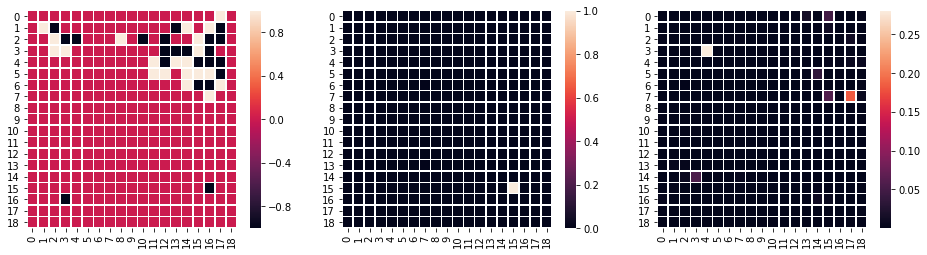

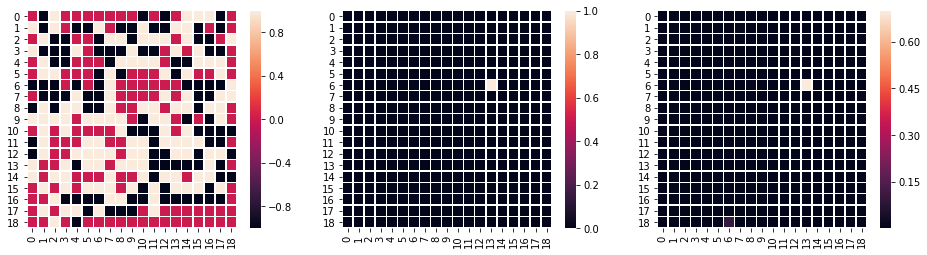

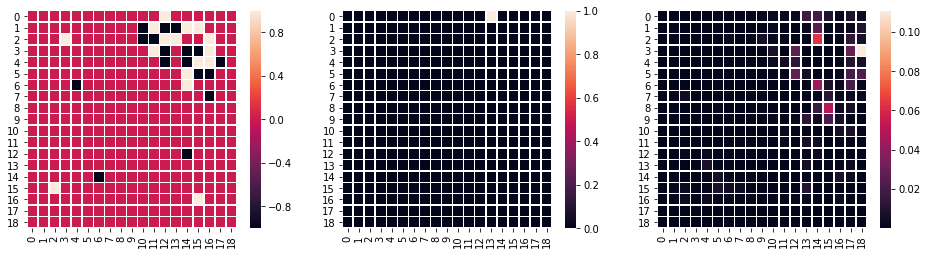

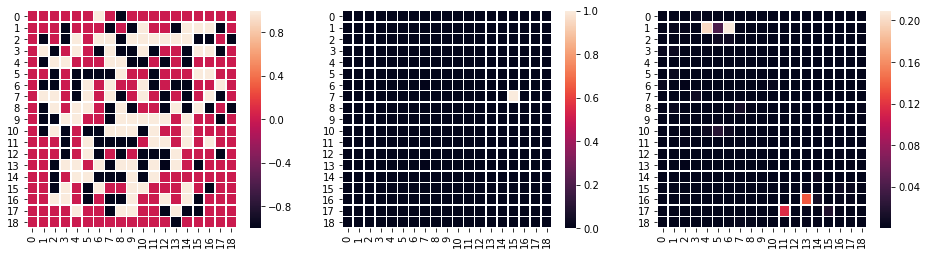

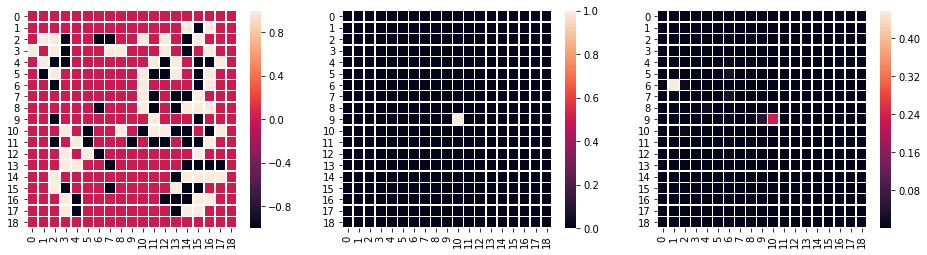

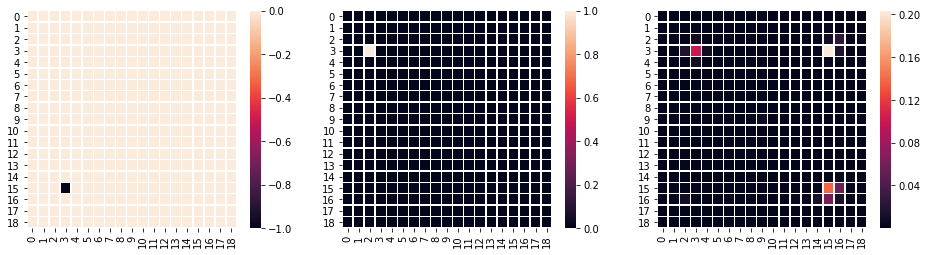

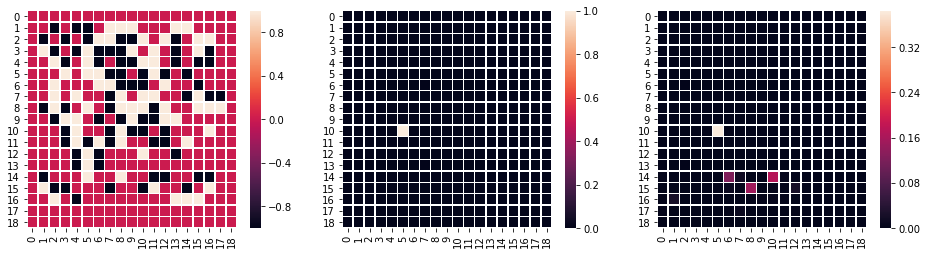

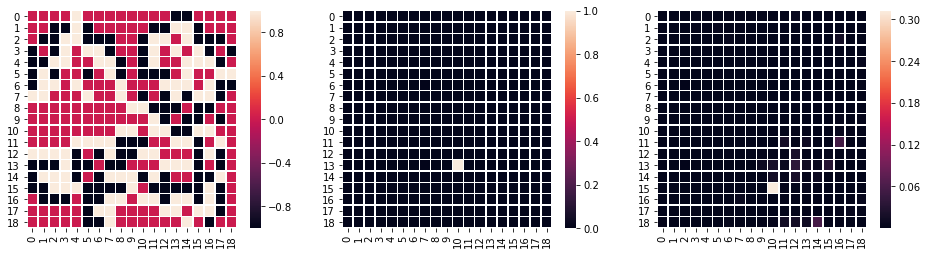

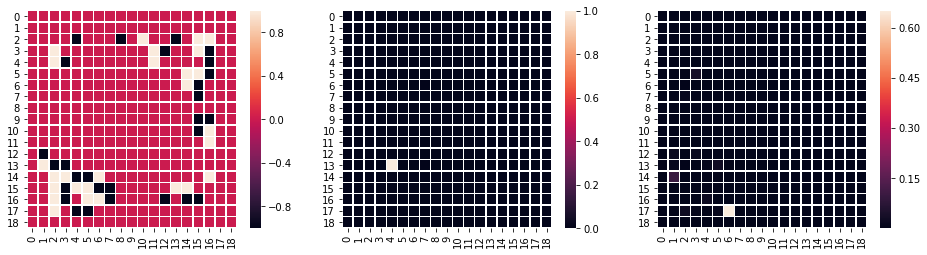

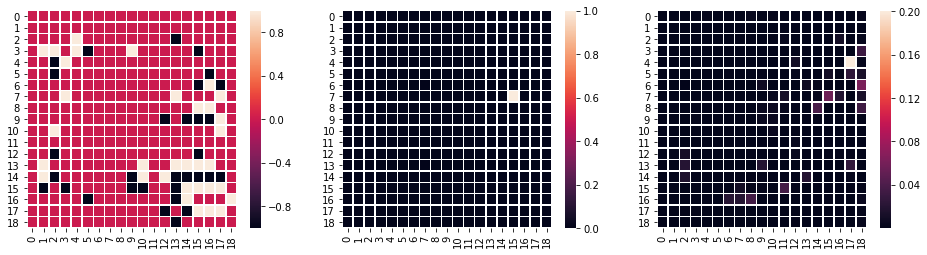

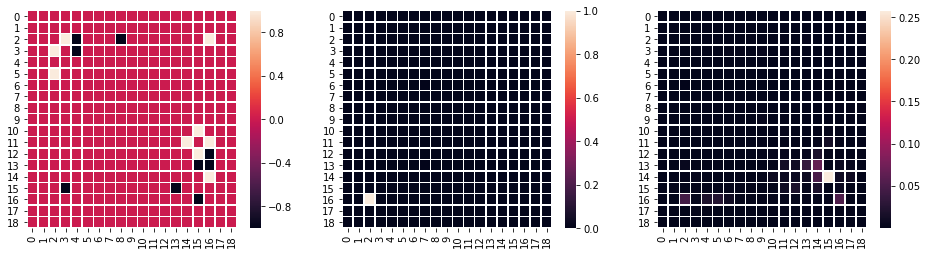

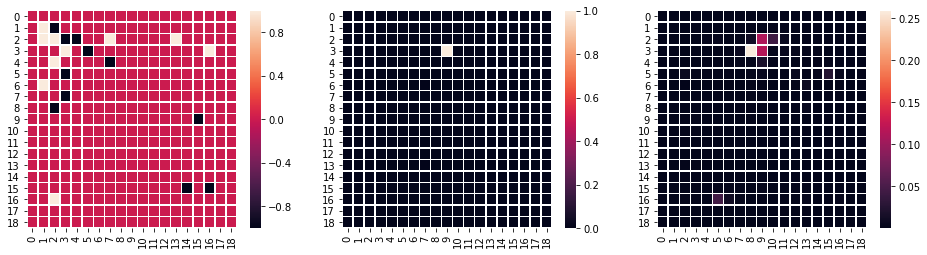

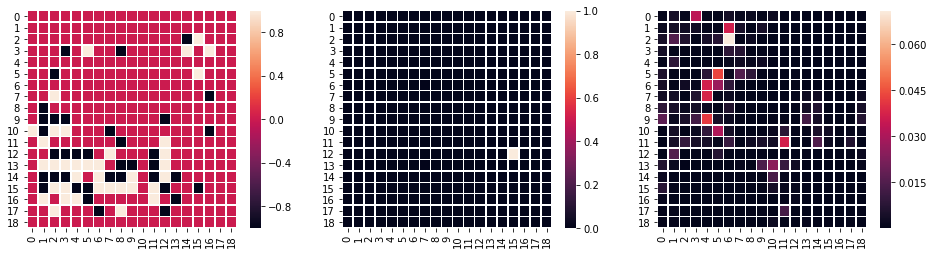

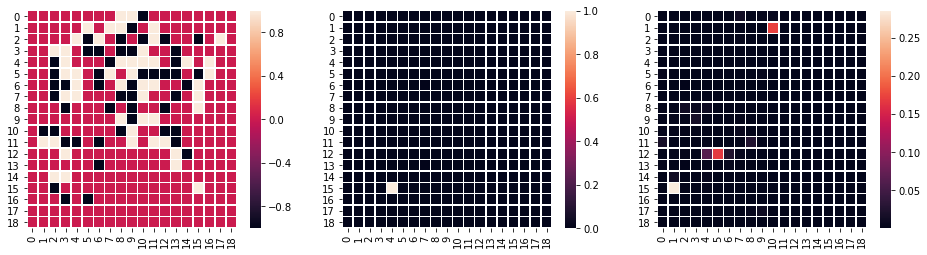

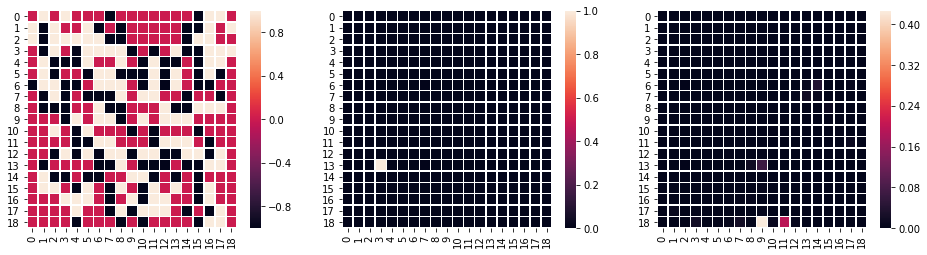

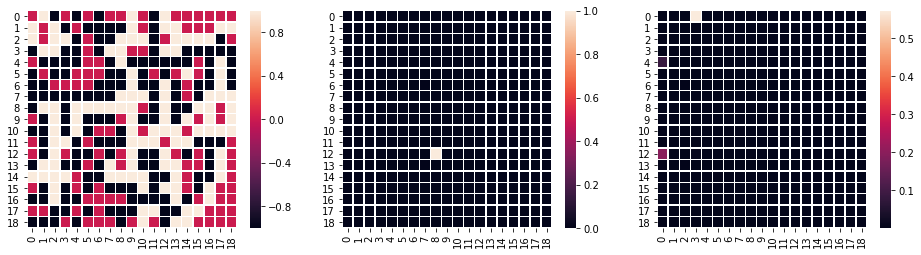

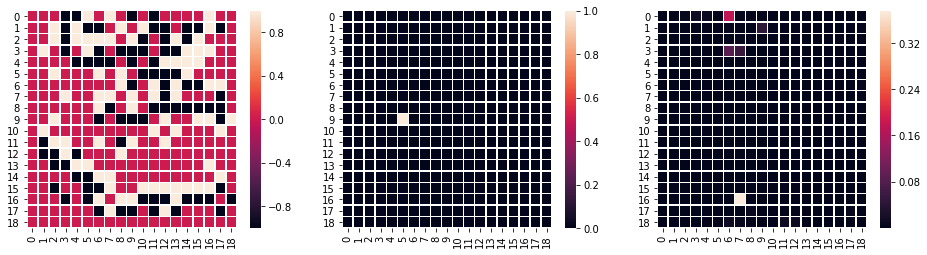

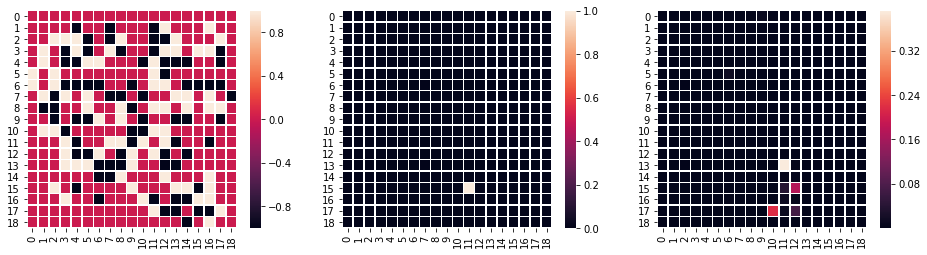

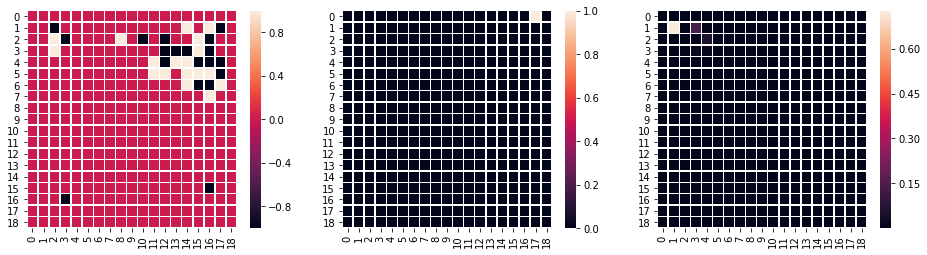

4.9189301679478605
Accuracy score: 0.192674


In [137]:
from sklearn.metrics import *
import seaborn as sns

def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            prediction = output.argmax(dim=1, keepdim=True)
            for i, move in enumerate(target):
                if i == 100:#move == prediction[i]: #i==0:
                    actual = np.zeros((BOARD_SIZE, BOARD_SIZE), dtype=float)
                    row = int(np.floor(target[i].item() / BOARD_SIZE))
                    col = int(target[i].item() - row*BOARD_SIZE)
                    actual[row, col] = 1.0
                    # draw plot
                    plt.figure(figsize=(16, 4))
                    plt.subplot(1, 3, 1)
                    ax = sns.heatmap(data[i][0].cpu(), linewidth=0.5)
                    plt.subplot(1, 3, 2)
                    ax = sns.heatmap(actual, linewidth=0.5)
                    plt.subplot(1, 3, 3)
                    ax = sns.heatmap(np.exp(output[i].view(BOARD_SIZE, BOARD_SIZE).cpu()), linewidth=0.5)
                    plt.show()
            #print(output[:, prediction], output[:, target])
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    test_loss /= len(test_loader.dataset)
    print(test_loss)
    return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = test_label_predictions(model, device, test_loader)
print('Accuracy score: %f' % accuracy_score(actuals, predictions))

In [51]:
from matplotlib import pyplot as plt
%matplotlib inline

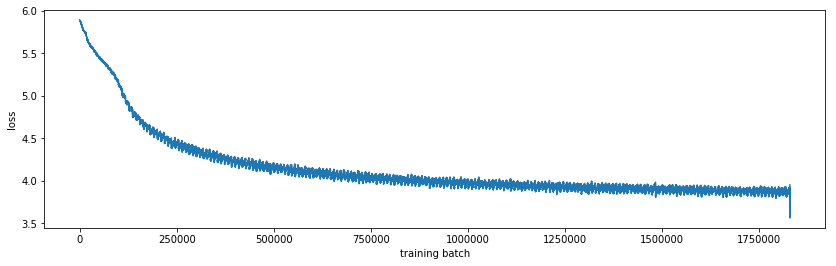

In [129]:
def mean(li): return sum(li)/len(li)
plt.figure(figsize=(14, 4))
plt.xlabel('training batch')
plt.ylabel('loss')
plt.plot([mean(losses[i:i+500]) for i in range(len(losses))])

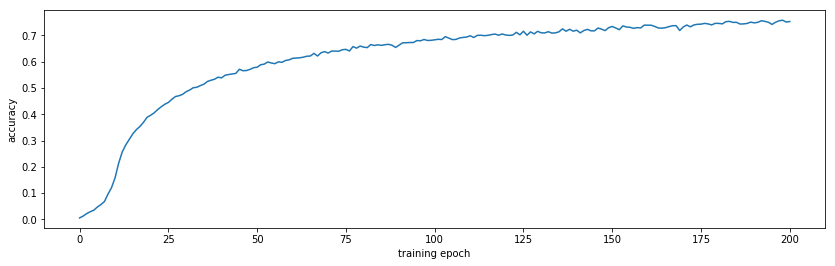

In [130]:
plt.figure(figsize=(14, 4))
plt.xlabel('training epoch')
plt.ylabel('accuracy')
plt.plot(accuracies)